In [ ]:

# Import libraries and modules
import numpy as np
np.random.seed(123)  # for reproducibility
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import Dropout
from keras.layers import Flatten, TimeDistributed, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras import metrics
from keras import backend

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis = -1))

def sensitivity(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     sensitivity = tp / (tp + fn)
     return sensitivity

# Recall is the same as the sensitivity
def recall(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     recall = tp / (tp + fn)
     return recall

def specificity(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     specificity = tn / (tn + fp)
     return specificity


def precision(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     precision = tp / (tp + fp)
     return precision


#(A) 2 class classification [A vs E]

In [ ]:
df=pd.read_csv("/content/drive/My Drive/mtech_finalyr_project/modified_Dataset/final_csv_with_shuffle_AvsE.csv")
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,tag
0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,-399.0,...,230.0,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,4
1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,456.0,...,-411.0,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,4
2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,164.0,...,-30.0,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,4
3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,-12.0,...,2.0,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,4
4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,40.0,...,-616.0,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-19.0,-39.0,-41.0,-16.0,5.0,14.0,6.0,-5.0,-20.0,-23.0,-21.0,-17.0,-11.0,-9.0,2.0,18.0,37.0,53.0,52.0,39.0,23.0,21.0,14.0,9.0,-8.0,-28.0,-42.0,-25.0,1.0,27.0,49.0,66.0,69.0,59.0,43.0,34.0,23.0,23.0,25.0,13.0,...,63.0,72.0,91.0,96.0,96.0,86.0,67.0,42.0,12.0,-3.0,-27.0,-43.0,-48.0,-41.0,-31.0,-17.0,-8.0,1.0,12.0,25.0,31.0,27.0,28.0,24.0,12.0,1.0,-1.0,0.0,4.0,5.0,0.0,3.0,16.0,33.0,48.0,55.0,67.0,60.0,46.0,0
196,-459.0,-778.0,-981.0,-1048.0,-734.0,-183.0,478.0,1040.0,1381.0,1502.0,1458.0,1312.0,1109.0,881.0,654.0,456.0,264.0,107.0,-31.0,-141.0,-219.0,-285.0,-327.0,-365.0,-354.0,-289.0,-204.0,-176.0,-308.0,-663.0,-1026.0,-1189.0,-787.0,-100.0,651.0,1117.0,1304.0,1344.0,1276.0,1149.0,...,-85.0,-57.0,-16.0,17.0,31.0,21.0,0.0,-29.0,-46.0,-42.0,-56.0,-108.0,-241.0,-444.0,-635.0,-787.0,-793.0,-665.0,-414.0,-108.0,185.0,413.0,522.0,515.0,435.0,305.0,174.0,82.0,25.0,1.0,-

In [ ]:
#converting tags into 0 nd 1
df.tag=df.tag.replace({4:1})
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,tag
0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,-399.0,...,230.0,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,1
1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,456.0,...,-411.0,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,1
2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,164.0,...,-30.0,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,1
3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,-12.0,...,2.0,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,1
4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,40.0,...,-616.0,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-19.0,-39.0,-41.0,-16.0,5.0,14.0,6.0,-5.0,-20.0,-23.0,-21.0,-17.0,-11.0,-9.0,2.0,18.0,37.0,53.0,52.0,39.0,23.0,21.0,14.0,9.0,-8.0,-28.0,-42.0,-25.0,1.0,27.0,49.0,66.0,69.0,59.0,43.0,34.0,23.0,23.0,25.0,13.0,...,63.0,72.0,91.0,96.0,96.0,86.0,67.0,42.0,12.0,-3.0,-27.0,-43.0,-48.0,-41.0,-31.0,-17.0,-8.0,1.0,12.0,25.0,31.0,27.0,28.0,24.0,12.0,1.0,-1.0,0.0,4.0,5.0,0.0,3.0,16.0,33.0,48.0,55.0,67.0,60.0,46.0,0
196,-459.0,-778.0,-981.0,-1048.0,-734.0,-183.0,478.0,1040.0,1381.0,1502.0,1458.0,1312.0,1109.0,881.0,654.0,456.0,264.0,107.0,-31.0,-141.0,-219.0,-285.0,-327.0,-365.0,-354.0,-289.0,-204.0,-176.0,-308.0,-663.0,-1026.0,-1189.0,-787.0,-100.0,651.0,1117.0,1304.0,1344.0,1276.0,1149.0,...,-85.0,-57.0,-16.0,17.0,31.0,21.0,0.0,-29.0,-46.0,-42.0,-56.0,-108.0,-241.0,-444.0,-635.0,-787.0,-793.0,-665.0,-414.0,-108.0,185.0,413.0,522.0,515.0,435.0,305.0,174.0,82.0,25.0,1.0,-

In [ ]:
# Time Steps of LSTM
data_length = 4096
timesteps = 2048
data_dim = data_length//timesteps
data_dim

2

In [ ]:
#breaking dataset into X nd y
df1=df.values     #df1 is numpy.ndarray and df is pandas.dataframe
X, y = df1[:, :-1], df1[:, -1]
print(df.shape)
print(X.shape)
print(y.shape)

(200, 4097)
(200, 4096)
(200,)


In [ ]:
#breaking X nd y into train nd test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train=X_train.reshape([X_train.shape[0], timesteps, data_dim])
X_test = X_test.reshape([X_test.shape[0], timesteps, data_dim])
y_train=np_utils.to_categorical(y_train, num_classes=2)
y_test=np_utils.to_categorical(y_test, num_classes=2)

(140, 4096)
(60, 4096)
(140,)
(60,)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 2048, 2)
(60, 2048, 2)
(140, 2)
(60, 2)


Epoch 1/100
3/3 [==============================] - 36s 656ms/step - loss: 0.6758 - sensitivity: 0.6934 - specificity: 0.6934 - accuracy: 0.6556 - val_loss: 0.5154 - val_sensitivity: 0.6833 - val_specificity: 0.6833 - val_accuracy: 0.6833
Epoch 2/100
3/3 [==============================] - 0s 176ms/step - loss: 0.4903 - sensitivity: 0.7845 - specificity: 0.7845 - accuracy: 0.7545 - val_loss: 0.3637 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_accuracy: 1.0000
Epoch 3/100
3/3 [==============================] - 0s 176ms/step - loss: 0.3394 - sensitivity: 0.9909 - specificity: 0.9909 - accuracy: 0.9890 - val_loss: 0.2666 - val_sensitivity: 0.9667 - val_specificity: 0.9667 - val_accuracy: 0.9667
Epoch 4/100
3/3 [==============================] - 0s 178ms/step - loss: 0.2559 - sensitivity: 0.9470 - specificity: 0.9470 - accuracy: 0.9516 - val_loss: 0.1897 - val_sensitivity: 0.9833 - val_specificity: 0.9833 - val_accuracy: 0.9833
Epoch 5/100
3/3 [==============================] - 

<IPython.core.display.Javascript object>

Sensitivity = 100.00%
Specificity = 100.00%
Classification Accuracy = 100.00%


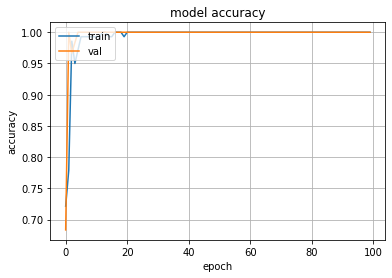

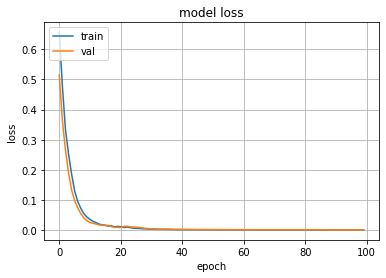

In [ ]:
nb_epoch=100

model = Sequential()

model.add(Bidirectional(LSTM(80, input_shape= (timesteps, data_dim), return_sequences = True)))
model.add(Dropout(0.1))

model.add(TimeDistributed(Dense(50)))

model.add(GlobalAveragePooling1D())

model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
#print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=nb_epoch)


plt.plot(history.history['specificity'], 'b--')
plt.plot(history.history['sensitivity'], 'g--')
plt.plot(history.history['accuracy'], 'r--')
plt.title('Model Different Metrics')
plt.ylabel('Metrics')
plt.xlabel('Epoch #')
plt.show()



scores = model.evaluate(X_test, y_test, verbose=0)
print("Sensitivity = %.2f%%" % (scores[1]*100))
print("Specificity = %.2f%%" % (scores[2]*100))
print("Classification Accuracy = %.2f%%" % (scores[3]*100))


%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
#check output of model
y_predict=model.predict(X_test)

# numpy implementation of argmax
from numpy import argmax
from numpy import asarray
# define vector
probs = asarray(y_predict)
print(probs.shape)
# get argmax
result = argmax(probs, axis=1)
print(result)

y_test_cm=argmax(y_test,axis=1)
print(result.shape)

(60, 2)
[0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1
 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0]
(60,)


In [ ]:

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test_cm, result)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_cm, result)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_cm, result, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_cm, result, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_cm, result, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_cm, result, target_names=['Class A', 'Class E']))

Confusion Matrix

[[30  0]
 [ 0 30]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

     Class A       1.00      1.00      1.00        30
     Class E       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



# Saving model nd its weight

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_AvsE.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_AvsE.h5")
print("Saved model to disk")
 

Saved model to disk


# (B.1) 2 class classification [ABCD vs E]

In [ ]:
df=pd.read_csv("/content/drive/My Drive/mtech_finalyr_project/modified_Dataset/final_csv_with_shuffle_ABvsCDvsE.csv")
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,tag
0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,-399.0,...,230.0,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,4
1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,456.0,...,-411.0,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,4
2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,164.0,...,-30.0,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,4
3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,-12.0,...,2.0,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,4
4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,40.0,...,-616.0,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,213.0,210.0,210.0,212.0,194.0,162.0,121.0,84.0,45.0,11.0,-13.0,-20.0,-27.0,-32.0,-31.0,-39.0,-49.0,-61.0,-72.0,-80.0,-85.0,-87.0,-93.0,-96.0,-97.0,-94.0,-82.0,-57.0,-18.0,-3.0,-11.0,-1.0,41.0,120.0,181.0,202.0,198.0,195.0,197.0,190.0,...,-110.0,-108.0,-112.0,-113.0,-112.0,-103.0,-100.0,-98.0,-95.0,-94.0,-92.0,-91.0,-89.0,-86.0,-84.0,-78.0,-70.0,-63.0,-53.0,-46.0,-37.0,-34.0,-29.0,-28.0,-23.0,-15.0,-13.0,-14.0,-9.0,-10.0,-5.0,-2.0,1.0,1.0,-2.0,-8.0,-9.0,-2.0,20.0,4
496,24.0,10.0,-9.0,-18.0,-9.0,-3.0,-2.0,-2.0,-9.0,-9.0,-14.0,-14.0,-24.0,-24.0,-12.0,-1.0,13.0,31.0,60.0,79.0,98.0,110.0,104.0,72.0,40.0,26.0,24.0,33.0,40.0,29.0,13.0,3.0,2.0,0.0,10.0,32.0,52.0,61.0,54.0,19.0,...,73.0,55.0,33.0,15.0,-5.0,-18.0,-24.0,-28.0,-15.0,12.0,33.0,48.0,47.0,36.0,19.0,16.0,31.0,56.0,69.0,75.0,67.0,66.0,76.0,93.0,88.0,65.0,56.0,58.0,63.0,48.0,29.0,3.0,-17.0,-14.0,-21.0,-29.0,-3

In [ ]:
df.tag=df.tag.replace({4:1,2:0})
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,tag
0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,-399.0,...,230.0,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,1
1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,456.0,...,-411.0,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,1
2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,164.0,...,-30.0,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,1
3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,-12.0,...,2.0,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,1
4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,40.0,...,-616.0,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,213.0,210.0,210.0,212.0,194.0,162.0,121.0,84.0,45.0,11.0,-13.0,-20.0,-27.0,-32.0,-31.0,-39.0,-49.0,-61.0,-72.0,-80.0,-85.0,-87.0,-93.0,-96.0,-97.0,-94.0,-82.0,-57.0,-18.0,-3.0,-11.0,-1.0,41.0,120.0,181.0,202.0,198.0,195.0,197.0,190.0,...,-110.0,-108.0,-112.0,-113.0,-112.0,-103.0,-100.0,-98.0,-95.0,-94.0,-92.0,-91.0,-89.0,-86.0,-84.0,-78.0,-70.0,-63.0,-53.0,-46.0,-37.0,-34.0,-29.0,-28.0,-23.0,-15.0,-13.0,-14.0,-9.0,-10.0,-5.0,-2.0,1.0,1.0,-2.0,-8.0,-9.0,-2.0,20.0,1
496,24.0,10.0,-9.0,-18.0,-9.0,-3.0,-2.0,-2.0,-9.0,-9.0,-14.0,-14.0,-24.0,-24.0,-12.0,-1.0,13.0,31.0,60.0,79.0,98.0,110.0,104.0,72.0,40.0,26.0,24.0,33.0,40.0,29.0,13.0,3.0,2.0,0.0,10.0,32.0,52.0,61.0,54.0,19.0,...,73.0,55.0,33.0,15.0,-5.0,-18.0,-24.0,-28.0,-15.0,12.0,33.0,48.0,47.0,36.0,19.0,16.0,31.0,56.0,69.0,75.0,67.0,66.0,76.0,93.0,88.0,65.0,56.0,58.0,63.0,48.0,29.0,3.0,-17.0,-14.0,-21.0,-29.0,-3

In [ ]:
#breaking dataset into X nd y
df1=df.values     #df1 is numpy.ndarray and df is pandas.dataframe
X, y = df1[:, :-1], df1[:, -1]
print(df.shape)
print(X.shape)
print(y.shape)

(500, 4097)
(500, 4096)
(500,)


In [ ]:
type(X_test)

numpy.ndarray

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train=X_train.reshape([X_train.shape[0], timesteps, data_dim])
X_test = X_test.reshape([X_test.shape[0], timesteps, data_dim])
y_train=np_utils.to_categorical(y_train, num_classes=2)
y_test=np_utils.to_categorical(y_test, num_classes=2)

(350, 4096)
(150, 4096)
(350,)
(150,)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(350, 2048, 2)
(150, 2048, 2)
(350, 2)
(150, 2)


In [ ]:
nb_epoch=100

model = Sequential()

model.add(Bidirectional(LSTM(80, input_shape= (timesteps, data_dim), return_sequences = True)))
model.add(Dropout(0.1))

model.add(TimeDistributed(Dense(50)))

model.add(GlobalAveragePooling1D())

model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
#print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=nb_epoch)


plt.plot(history.history['specificity'], 'b--')
plt.plot(history.history['sensitivity'], 'g--')
plt.plot(history.history['accuracy'], 'r--')
plt.title('Model Different Metrics')
plt.ylabel('Metrics')
plt.xlabel('Epoch #')
plt.show()



scores = model.evaluate(X_test, y_test, verbose=0)
print("Sensitivity = %.2f%%" % (scores[1]*100))
print("Specificity = %.2f%%" % (scores[2]*100))
print("Classification Accuracy = %.2f%%" % (scores[3]*100))


%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
scores

[0.004568497184664011, 1.0, 1.0, 1.0]

In [ ]:
#check output of model
y_predict=model.predict(X_test)

# numpy implementation of argmax
from numpy import argmax
from numpy import asarray
# define vector
probs = asarray(y_predict)
print(probs.shape)
# get argmax
result = argmax(probs, axis=1)
print(result)

y_test_cm=argmax(y_test,axis=1)
print(result.shape)

(150, 2)
[0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0]
(150,)


In [ ]:
confusion = confusion_matrix(y_test_cm, result)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_cm, result)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_cm, result, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_cm, result, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_cm, result, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_cm, result, target_names=['Class ABCD', 'Class E']))

Confusion Matrix

[[120   0]
 [  0  30]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

  Class ABCD       1.00      1.00      1.00       120
     Class E       1.00      1.00      1.00        30

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_ABCDvsE.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_ABCDvsE.h5")
print("Saved model to disk")
 

In [ ]:
#dataset of size 150*(4096/2)
print("shape of X_test: ",X_test.shape)
df_2048=X_test[:,0:2048].copy()
print("shape of df_2048: ",df_2048.shape)

shape of X_test:  (150, 4096)
shape of df_2048:  (150, 2048)


In [ ]:
df_2048

array([[-148., -155., -156., ...,   30.,   38.,   41.],
       [  45.,   52.,   79., ...,  -48.,  -64.,  -71.],
       [ -20.,   -3.,    2., ...,   24.,   21.,    5.],
       ...,
       [  40.,   60.,   74., ..., -138., -135., -128.],
       [ -91., -116.,  -70., ...,  -12.,  -16.,  -25.],
       [ -41.,  -40.,  -39., ...,  -35.,  -70.,  -90.]])

In [ ]:
X_test_2048 = pd.concat([pd.DataFrame(df_2048), pd.DataFrame(df_2048)], axis=1,  ignore_index=True)
X_test_2048

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-148.0,-155.0,-156.0,-156.0,-150.0,-147.0,-141.0,-135.0,-131.0,-124.0,-114.0,-100.0,-80.0,-51.0,-21.0,2.0,22.0,37.0,49.0,53.0,50.0,46.0,38.0,27.0,21.0,19.0,18.0,21.0,22.0,22.0,24.0,13.0,-1.0,-16.0,-30.0,-32.0,-46.0,-51.0,-56.0,-53.0,...,-43.0,-35.0,-28.0,-16.0,-10.0,0.0,13.0,22.0,29.0,31.0,31.0,35.0,36.0,43.0,48.0,41.0,29.0,20.0,16.0,8.0,-8.0,-16.0,-22.0,-18.0,-15.0,-18.0,-21.0,-14.0,-7.0,-2.0,0.0,3.0,7.0,10.0,15.0,19.0,21.0,24.0,30.0,38.0
1,45.0,52.0,79.0,117.0,146.0,160.0,178.0,210.0,235.0,250.0,248.0,240.0,229.0,228.0,209.0,194.0,170.0,154.0,131.0,122.0,103.0,91.0,79.0,77.0,86.0,84.0,70.0,55.0,21.0,2.0,-4.0,-8.0,-12.0,-32.0,-47.0,-60.0,-63.0,-71.0,-77.0,-94.0,...,68.0,89.0,83.0,102.0,106.0,117.0,123.0,109.0,89.0,33.0,-2.0,-21.0,-26.0,-14.0,0.0,19.0,52.0,46.0,10.0,-28.0,-39.0,-22.0,2.0,28.0,31.0,20.0,15.0,6.0,6.0,-12.0,-8.0,-3.0,-10.0,-36.0,-57.0,-73.0,-56.0,-55.0,-48.0,-64.0
2,-20.0,-3.0,2.0,16.0,29.0,36.0,34.0,29.0,38.0,26.0,6.0,-1.0,-4.0,13.0,24.0,38.0,27.0,21.0,15.0,12.0,5.0,7.0,3.0,-7.0,-15.0,-18.0,-13.0,-19.0,-14.0,-17.0,-15.0,-4.0,-5.0,-11.0,-4.0,10.0,23.0,20.0,5.0,-6.0,...,-68.0,-72.0,-64.0,-50.0,-34.0,-22.0,-19.0,-13.0,-25.0,-48.0,-52.0,-53.0,-41.0,-30.0,-16.0,-5.0,-9.0,-6.0,-16.0,-27.0,-35.0,-32.0,-32.0,-26.0,-12.0,-19.0,-38.0,-56.0,-54.0,-55.0,-46.0,-48.0,-42.0,-43.0,-26.0,-8.0,6.0,22.0,24.0,21.0
3,-28.0,-20.0,-18.0,-22.0,-23.0,-23.0,-15.0,-8.0,-7.0,-3.0,8.0,19.0,26.0,40.0,45.0,52.0,49.0,52.0,49.0,48.0,50.0,42.0,37.0,29.0,31.0,26.0,28.0,30.0,27.0,23.0,11.0,9.0,-2.0,-2.0,6.0,7.0,-4.0,-5.0,-5.0,-1.0,...,-21.0,-22.0,-25.0,-25.0,-24.0,-17.0,-10.0,-5.0,-11.0,-4.0,9.0,12.0,15.0,21.0,25.0,24.0,28.0,31.0,37.0,40.0,38.0,35.0,26.0,19.0,9.0,1.0,-5.0,6.0,12.0,10.0,14.0,-2.0,-8.0,-16.0,-16.0,-12.0,-16.0,-6.0,-7.0,-13.0
4,23.0,144.0,228.0,260.0,255.0,218.0,178.0,126.0,60.0,6.0,-47.0,-90.0,-143.0,-181.0,-221.0,-264.0,-305.0,-346.0,-406.0,-506.0,-565.0,-474.0,-232.0,76.0,309.0,415.0,484.0,552.0,594.0,614.0,578.0,494.0,400.0,293.0,192.0,104.0,26.0,-22.0,-32.0,-46.0,...,-146.0,-202.0,-291.0,-344.0,-286.0,-126.0,82.0,237.0,326.0,344.0,313.0,278.0,262.0,264.0,282.0,289.0,276.0,273.0,238.0,187.0,110.0,17.0,-51.0,-94.0,-133.0,-161.0,-168.0,-179.0,-181.0,-203.0,-231.0,-275.0,-367.0,-357.0,-297.0,-139.0,28.0,140.0,240.0,294.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-55.0,-48.0,-48.0,-38.0,-23.0,0.0,11.0,22.0,21.0,3.0,-10.0,-16.0,-17.0,-18.0,-25.0,-43.0,-71.0,-87.0,-84.0,-67.0,-53.0,-36.0,-22.0,-20.0,-13.0,-3.0,-1.0,-12.0,-29.0,-50.0,-55.0,-37.0,-5.0,17.0,9.0,-9.0,-35.0,-41.0,-32.0,-4.0,...,42.0,54.0,61.0,62.0,60.0,39.0,23.0,20.0,23.0,27.0,21.0,7.0,-18.0,-33.0,-29.0,-27.0,-23.0,-20.0,-7.0,6.0,22.0,35.0,43.0,33.0,11.0,3.0,-7.0,5.0,19.0,26.0,17.0,12.0,13.0,16.0,31.0,54.0,81.0,106.0,130.0,142.0
146,-39.0,-27.0,-16.0,-3.0,17.0,34.0,73.0,105.0,142.0,155.0,156.0,149.0,135.0,114.0,91.0,60.0,53.0,71.0,105.0,133.0,138.0,120.0,110.0,98.0,97.0,90.0,85.0,72.0,70.0,55.0,42.0,2.0,-41.0,-90.0,-122.0,-142.0,-167.0,-195.0,-223.0,-227.0,...,1.0,6.0,-5.0,-9.0,-1.0,5.0,24.0,43.0,72.0,94.0,106.0,107.0,125.0,144.0,165.0,173.0,174.0,181.0,198.0,205.0,220.0,220.0,224.0,209.0,188.0,163.0,136.0,118.0,104.0,91.0,60.0,41.0,17.0,2.0,-3.0,4.0,2.0,2.0,0.0,-5.0
147,40.0,60.0,74.0,70.0,67.0,48.0,44.0,44.0,52.0,69.0,73.0,66.0,70.0,78.0,71.0,68.0,57.0,55.0,35.0,24.0,10.0,-13.0,-24.0,-24.0,-27.0,-28.0,-21.0,-13.0,6.0,31.0,37.0,27.0,-1.0,2.0,0.0,0.0,-13.0,-30.0,-21.0,-6.0,...,-

In [ ]:
print(type(X_test_2048))
X_test_2048=pd.DataFrame.to_numpy(X_test_2048)
print(type(X_test_2048))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [ ]:
X_test_2048 = X_test_2048.reshape([X_test_2048.shape[0], timesteps, data_dim])
y_test=np_utils.to_categorical(y_test, num_classes=2)
#print(X_test_2048)
print(X_test_2048.shape)
print(y_test.shape)

# (B.2) Testing model on T=23.6/2 interval

In [1]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_ABCDvsE.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_ABCDvsE.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
score = loaded_model.evaluate(X_test_2048,y_test, verbose=1)
print(" %.2f%%" % ( score[1]*100))



Loaded model from disk


NameError: ignored

# (B.3) Testing model on T=23.6/4 interval

In [ ]:
#dataset of size 150*(4096/4)
print("shape of X_test: ",X_test.shape)
df_1024=X_test[:,0:1024].copy()
print("shape of df_2048: ",df_1024.shape)


X_test_1024 = pd.concat([pd.DataFrame(df_1024), pd.DataFrame(df_1024),pd.DataFrame(df_1024),pd.DataFrame(df_1024)], axis=1,  ignore_index=True)
print("\nshape of df_1024: ",df_1024.shape)
print(df_1024)

X_test_1024=pd.DataFrame.to_numpy(X_test_1024)

X_test_1024 = X_test_1024.reshape([X_test_1024.shape[0], timesteps, data_dim])
y_test=np_utils.to_categorical(y_test, num_classes=2)

from keras.models import model_from_json
# load json and create model
json_file = open('/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_ABCDvsE.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_ABCDvsE.h5")
print("Loaded model from disk")


# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
score = loaded_model.evaluate(X_test_1024,y_test, verbose=1)
print(" %.2f%%" % ( score[1]*100))

shape of X_test:  (60, 4096)
shape of df_2048:  (60, 1024)

shape of df_1024:  (60, 1024)
[[  56.   55.   38. ...  -68.  -73.  -64.]
 [ 176.  186.  189. ...  -89. -113. -103.]
 [  13.   30.   42. ...   -9.  -34.  -22.]
 ...
 [-113. -185. -269. ... -295. -400. -393.]
 [-133. -144. -113. ... -127. -132. -140.]
 [ -12.    6.   13. ...   -6.   -4.  -14.]]
Loaded model from disk
2/2 [==============================] - 33s 108ms/step - loss: 0.0012 - sensitivity: 1.0000 - specificity: 1.0000 - accuracy: 1.0000
 100.00%


# (B.4) Testing model on T=23.6/8 interval

In [ ]:
#dataset of size 150*(4096/8)
print("shape of X_test: ",X_test.shape)
df_512=X_test[:,0:512].copy()
print("shape of df_2048: ",df_512.shape)


X_test_512 = pd.concat([pd.DataFrame(df_512), pd.DataFrame(df_512),pd.DataFrame(df_512),pd.DataFrame(df_512) , pd.DataFrame(df_512), pd.DataFrame(df_512),pd.DataFrame(df_512),pd.DataFrame(df_512)], axis=1,  ignore_index=True)
print("\nshape of df_512: ",df_512.shape)
print(df_512)

X_test_512=pd.DataFrame.to_numpy(X_test_512)

X_test_512 = X_test_512.reshape([X_test_512.shape[0], timesteps, data_dim])
y_test=np_utils.to_categorical(y_test, num_classes=2)

from keras.models import model_from_json
# load json and create model
json_file = open('/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_ABCDvsE.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/mtech_finalyr_project/2class problem/model_2class_ABCDvsE.h5")
print("Loaded model from disk")


# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
score = loaded_model.evaluate(X_test_512,y_test, verbose=1)
print(" %.2f%%" % ( score[1]*100))

shape of X_test:  (60, 4096)
shape of df_2048:  (60, 512)

shape of df_512:  (60, 512)
[[  56.   55.   38. ...  -98. -130. -111.]
 [ 176.  186.  189. ...  237.  233.  231.]
 [  13.   30.   42. ...  -46.  -56.  -65.]
 ...
 [-113. -185. -269. ...  -58.  -78.  -28.]
 [-133. -144. -113. ...  -40.  -45.  -51.]
 [ -12.    6.   13. ...   36.   36.   13.]]
Loaded model from disk
2/2 [==============================] - 1s 108ms/step - loss: 0.0147 - sensitivity: 1.0000 - specificity: 1.0000 - accuracy: 1.0000
 100.00%


In [ ]:
print(X_test_512.shape)

print(y_test.shape)

(60, 2048, 2)
(60, 2)
